In [1]:
import pandas as pd
import numpy as np

In [2]:
url = 'https://drive.google.com/file/d/1mqONs6PP8xwY__zvRO-u1E72kQj9ZK8E/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
train_data = pd.read_pickle(path)

url = 'https://drive.google.com/file/d/1ZDy2iShK0wo5ifEZSeNqcEGk7-LloeX6/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
test_data = pd.read_pickle(path)

In [3]:
import os
import re
import json
import string
import numpy as np
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import re, string


configuration = BertConfig()  # default parameters and configuration for BERT

max_len = 50

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

In [6]:
# creating input for bert
class Example:
    def __init__(self, question, context, start_char_idx, answer_text, inference=False):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer = answer_text
        self.skip = False
        self.inference = inference

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer
        start_char_idx = self.start_char_idx

        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets



def create_examples(raw_data):
    squad_examples = []
    for i, row in raw_data.iterrows():
        question = row['question']
        context = row['new_context']
        answer_text = row['answer']
        start_char_idx = row['start_index']
        squad_eg = Example(
            question, context, start_char_idx, answer_text
        )
        squad_eg.preprocess()
        squad_examples.append(squad_eg)
    return squad_examples



def create_inputs_targets(squad_examples, inference=False):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    start_token_idx = []
    end_token_idx = []
    answers = []

    if inference:
        for item in squad_examples:
            if not item.skip:
                input_ids.append(item.input_ids)
                token_type_ids.append(item.token_type_ids)
                attention_mask.append(item.attention_mask)
        return (torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask))
    else:

        for item in squad_examples:
            if not item.skip:
                input_ids.append(item.input_ids)
                token_type_ids.append(item.token_type_ids)
                attention_mask.append(item.attention_mask)
                start_token_idx.append(item.start_token_idx)
                end_token_idx.append(item.end_token_idx)
                answers.append(item.answer)

        return (
            torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask),
            torch.tensor(start_token_idx), torch.tensor(end_token_idx), answers
        )

In [7]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask, start_token_idx, end_token_idx, answers):
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.answers = answers

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'token_type_ids': torch.tensor(self.token_type_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'start_token_idx': torch.tensor(self.start_token_idx[idx], dtype=torch.long),
            'end_token_idx': torch.tensor(self.end_token_idx[idx], dtype=torch.long),
            'answers': self.answers[idx]
        }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
train_examples = create_examples(train_data)
eval_examples = create_examples(test_data)

train_dataset = QADataset(*create_inputs_targets(train_examples))
eval_dataset = QADataset(*create_inputs_targets(eval_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [9]:
class QAModel(nn.Module):
    def __init__(self, max_len):
        super(QAModel, self).__init__()
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'modelForQuestionAnswering', 'bert-base-uncased')
        self.linear = nn.Linear(max_len, max_len)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        start_logits = self.flatten(self.linear(outputs.start_logits))
        end_logits = self.flatten(self.linear(outputs.end_logits))
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
        return start_probs, end_probs

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('match metric')
    plt.show()

In [11]:
# class for calculating metric
# if prediction is contained in answer the prediction is successful
class Match:
    def __init__(self, tokenizer):
           self.tokenizer = tokenizer
           
    def normalize_text(self, text):
        text = text.lower()

        # Remove punctuations
        exclude = set(string.punctuation)
        text = "".join(ch for ch in text if ch not in exclude)

        # Remove articles
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        text = re.sub(regex, " ", text)

        # Remove extra white space
        text = " ".join(text.split())
        return text
    
    def metric(self, input_ids, start_prob, end_prob, y_true):
        correct_count = 0
        for i in range(len(input_ids)):
            input_id = input_ids[i].cpu().numpy()
            pred_start_indices = torch.argmax(start_prob[i]).item()
            pred_end_indices = torch.argmax(end_prob[i]).item()

            # convert tokens to strings
            pred_answer = self.tokenizer.decode(input_id[pred_start_indices:pred_end_indices+1], skip_special_tokens=True)

            normalized_pred_ans = self.normalize_text(pred_answer)
            normalized_true_ans = self.normalize_text(y_true[i])
            if normalized_true_ans in normalized_pred_ans:
                correct_count += 1
        accuracy = correct_count / len(y_true)
        return accuracy

In [12]:
def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training loss over the last epoch
      - val_mse: validation loss after the last epoch
    '''

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    model.train()
    for epoch in range(1, num_epochs + 1):
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader
        
        for i, batch in enumerate(pbar, 1):

            input_ids = batch['input_ids'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_labels = batch['start_token_idx'].to(device)
            end_labels = batch['end_token_idx'].to(device)
            answers = batch["answers"]
            
            optimizer.zero_grad()

            start_probs, end_probs = model(input_ids, token_type_ids, attention_mask)
            loss_start = criterion(start_probs, start_labels)
            loss_end = criterion(end_probs, end_labels)
            loss = (loss_start + loss_end) / 2
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(input_ids, start_probs, end_probs, answers)
                running_loss += loss.item()
                running_metric += metric_value

        train_losses += [running_loss / len(train_loader)]
        train_metrics += [running_metric / len(train_loader)]

        print(f'Epoch {epoch}/{num_epochs} completed')

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader
        with torch.no_grad():
            for i, batch in enumerate(pbar, 1):
                
                input_ids = batch['input_ids'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                start_labels = batch['start_token_idx'].to(device)
                end_labels = batch['end_token_idx'].to(device)
                answers = batch["answers"]

                    
                start_probs, end_probs = model(input_ids, token_type_ids, attention_mask)
                loss_start = criterion(start_probs, start_labels)
                loss_end = criterion(end_probs, end_labels)
                loss = (loss_start + loss_end) / 2
                
                metric_value = metric(input_ids, start_probs, end_probs, answers)

                running_loss += loss.item()
                running_metric += metric_value

            val_losses += [running_loss / len(val_loader)]
            val_metrics += [running_metric / len(val_loader)]

            if verbose:
                plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation match metric: {val_metrics[-1]:.3f}')

    return train_metrics, val_metrics, train_losses, val_losses

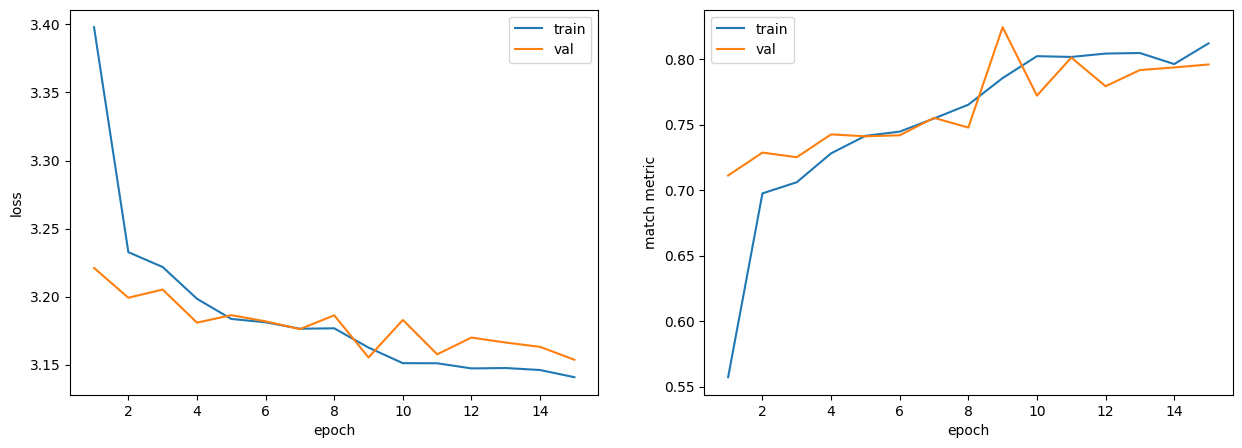

Validation match metric: 0.796


In [13]:
from tqdm.notebook import tqdm


model = QAModel(max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
metric = Match(tokenizer).metric

num_epochs = 15

train_metrics, val_metrics, train_losses, val_losses = train_and_validate(model, optimizer, criterion, metric, train_loader, eval_loader,
                       num_epochs, verbose=True)

In [14]:
torch.save(model.state_dict(), "fine_tuned_bert_qna.pt")

In [41]:
def get_attributes(model, tokenizer, object: str, context: str):
    question = f"what are attributes of {object}?"

    squad_eg = Example(
            question, context, inference=True
        )
    squad_eg.preprocess()
    input_ids, token_type_ids, attention_mask = create_inputs_targets([squad_eg], inference=True)
    with torch.no_grad():
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        start_probs, end_probs = model(input_ids, token_type_ids, attention_mask)

        input_id = input_ids.cpu().numpy()[0]
        pred_start_indices = torch.argmax(start_probs[0]).item()
        pred_end_indices = torch.argmax(end_probs[0]).item()

        # convert tokens to strings
        pred_answer = tokenizer.decode(input_id[pred_start_indices:pred_end_indices+1], skip_special_tokens=True)
        
    return pred_answer

In [48]:
model = model
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

object = "hat"
context = "small car blue red hat"
get_attributes(model, tokenizer, object, context)

'red'